<a href="https://colab.research.google.com/github/Archi2903/AI-in-Engenery/blob/main/Project_CNN%20DDPM%20in_EM_Russia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Energy resources and artificial intelligence[202502-ENR4320-001]
22251844 이도윤

#Denoising TEM Data with CNN(feedback) Autoencoder
This project will be demonstrates how a Convolutian Network Autoencoder can effectively suppress complex noise types in Transient Electromagnetic (TEM) decay signals.
Synthetic data are generated to simulate realistic noisy conditions, and the model learns to reconstruct the underlying clean signal from these corrupted observations.

2. Data Generation

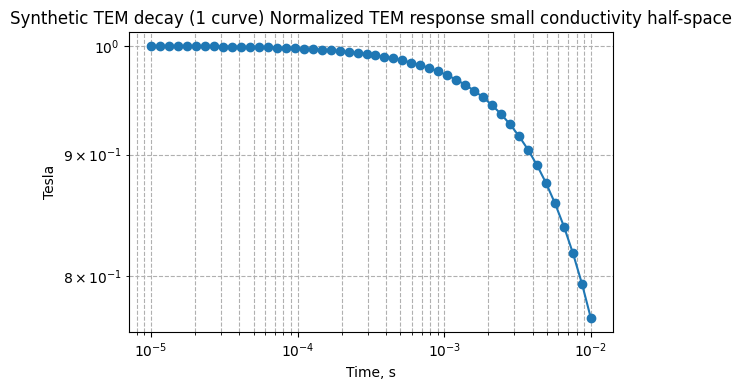

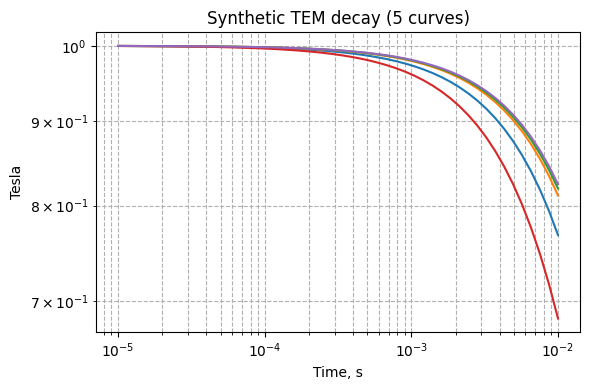

In [1]:
# Synthetic TEM Data Generation
# Synthetic data emulate realistic TEM decays using sums of exponential

import numpy as np
import matplotlib.pyplot as plt

# Example: generate one synthetic clean TEM decay signal (normalized)
def generate_clean_signal(n_points=50):
    t = np.logspace(-5, -2, n_points)  # time (s)
    y = np.zeros_like(t)

    # Sum of a few decaying exponentials(stacking)
    for A, tau in zip(np.random.uniform(0.5,1.5,3), np.random.uniform(0.01,0.1,3)):
        y += A * np.exp(-t/tau)
    y = y / np.max(y)  # normalize amplitude
    return t, y

# Generate dataset
n_samples = 200
times = []
clean_signals = []
for i in range(n_samples):
    t, y = generate_clean_signal()
    times.append(t)
    clean_signals.append(y)

# Plot example
# 1 curve from 200
t_plot = times[0]
y_plot = clean_signals[0]

plt.figure(figsize=(6, 4))
plt.loglog(t_plot, y_plot, marker='o')  # Log scale
plt.xlabel("Time, s")
plt.ylabel("Tesla")
plt.title("Synthetic TEM decay (1 curve) Normalized TEM response small conductivity half-space")
plt.grid(True, which="both", ls="--")
plt.tight_layout()


plt.figure(figsize=(6, 4))
for i in range(5):  # 5curve
    plt.loglog(times[i], clean_signals[i])
plt.xlabel("Time, s")
plt.ylabel("Tesla")
plt.title("Synthetic TEM decay (5 curves)")
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()


Dataset shape: (200, 50, 1) (200, 50, 1)


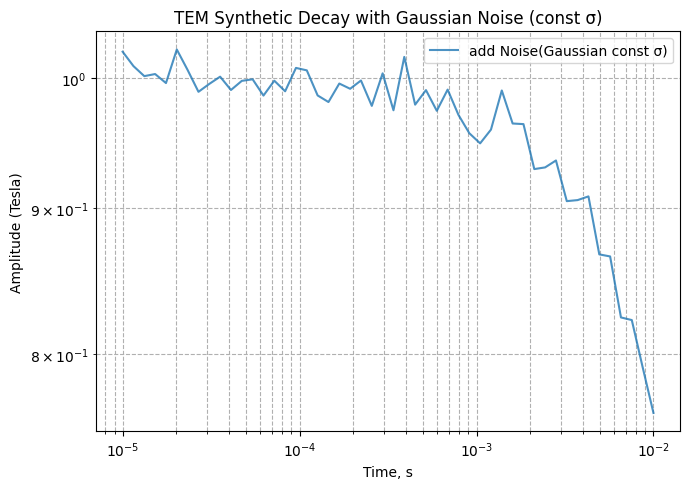

In [2]:
# add Gaussian noise in Clean signal (const variance)
def add_gaussian_const_noise(y):
    y = np.array(y)
    sigma_const = 0.01 * np.max(y)
    noisy = y + np.random.normal(0, sigma_const, size=y.shape)
    return noisy

# Make Dataset for training
X_noisy = []
Y_clean = []

for t, y in zip(times, clean_signals):
    noisy = add_gaussian_const_noise(y)
    X_noisy.append(noisy.reshape(-1, 1))
    Y_clean.append(y.reshape(-1, 1))

X_noisy = np.array(X_noisy)
Y_clean = np.array(Y_clean)

print("Dataset shape:", X_noisy.shape, Y_clean.shape)

# Plot
t_example = times[0]
y_example = clean_signals[0]
noisy_example = add_gaussian_const_noise(y_example)

plt.figure(figsize=(7, 5))
#plt.loglog(t_example, y_example, label="Clean Time Domain Responce", linewidth=2)
plt.loglog(t_example, noisy_example, label="add Noise(Gaussian const σ)", alpha=0.8)

plt.xlabel("Time, s")
plt.ylabel("Amplitude (Tesla)")
plt.title("TEM Synthetic Decay with Gaussian Noise (const σ)")
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv1D

timesteps = X_noisy.shape[1]
features = 1

model = Sequential([
    # Input data
    InputLayer(input_shape=(timesteps, features)),

    # Encoder 128,64,32
    Conv1D(128, kernel_size=5, padding='same', activation='relu'),
    Conv1D(64, kernel_size=5, padding='same', activation='relu'),
    Conv1D(32, kernel_size=5, padding='same', activation='relu'),

    # Decoder 32,64,128
    Conv1D(32, kernel_size=5, padding='same', activation='relu'),
    Conv1D(64, kernel_size=5, padding='same', activation='relu'),
    Conv1D(128, kernel_size=5, padding='same', activation='relu'),

    # Acually stacking summ all (NOT LAYER) for visual!!!!!!!
    Conv1D(1, kernel_size=6, padding='same', activation='linear')
])

model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 50, 128)        │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 50, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 50, 32)         │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 50, 32)         │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 50, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 50, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 50, 1)          │           769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,377 (427.25 KB)

 Trainable params: 109,377 (427.25 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
model.compile(optimizer='adam', loss='mse')


In [5]:
history = model.fit(
    X_noisy, Y_clean,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 508ms/step - loss: 0.6809 - val_loss: 0.1947
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1091 - val_loss: 0.0699
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0489 - val_loss: 0.0195
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0209 - val_loss: 0.0136
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0144 - val_loss: 0.0083
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0074 - val_loss: 0.0036
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0033 - val_loss: 0.0016
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014 - val_loss: 9.5344e-04
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.4419e-04 - val_loss: 6.0289e-04
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6677e-04 - val_loss: 3.6603e-04
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.1902e-04 - val_loss: 2.1574e-04
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss

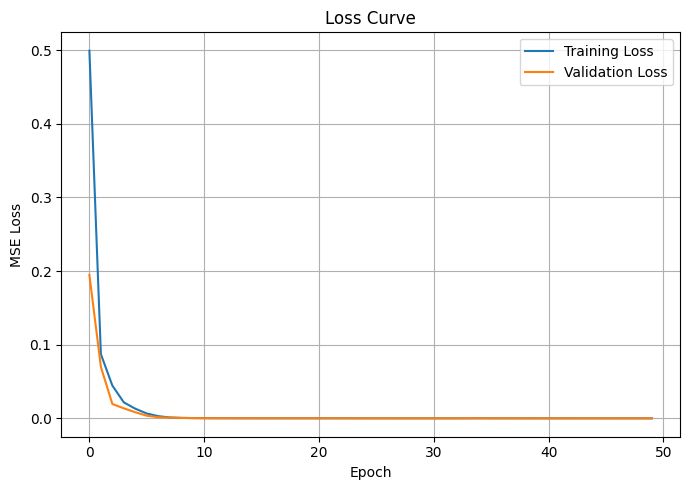

In [6]:
import matplotlib.pyplot as plt

#  Loss curve
plt.figure(figsize=(7,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


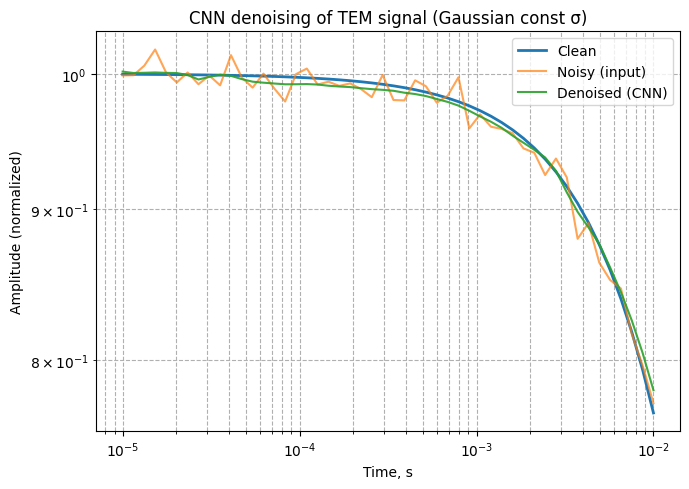

In [7]:
import matplotlib.pyplot as plt


idx = 0
x_test = X_noisy[idx:idx+1]         # shape (1, T, 1)
y_true = Y_clean[idx].squeeze()     # clean
y_noisy = X_noisy[idx].squeeze()    # noisy
y_pred = model.predict(x_test)[0].squeeze()  # denoised

t = times[idx]

plt.figure(figsize=(7, 5))
plt.loglog(t, y_true, label="Clean", linewidth=2)
plt.loglog(t, y_noisy, label="Noisy (input)", alpha=0.7)
plt.loglog(t, y_pred, label="Denoised (CNN)", alpha=0.9)

plt.xlabel("Time, s")
plt.ylabel("Amplitude (normalized)")
plt.title("CNN denoising of TEM signal (Gaussian const σ)")
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, X_noisy, Y_clean):

    # Predict value
    preds = model.predict(X_noisy)
    preds = preds.reshape(len(preds), -1)
    Y = Y_clean.reshape(len(Y_clean), -1)


    # MSE(mean squared Error)
    mse = mean_squared_error(Y.flatten(), preds.flatten())

    # RMS(sqrt mean squared Error)
    rmse = np.sqrt(mse)

    # MAE(mean absolute error)
    mae = mean_absolute_error(Y.flatten(), preds.flatten())

    # R²(Coefficient of Determination)
    r2 = r2_score(Y.flatten(), preds.flatten())

    # Print
    print("CNN for Time Domain Electro Magnrtic Model Evaluation ")
    print(f"MSE  (Mean Squared Error):       {mse:.8f}")
    print(f"RMSE (Root MSE):                 {rmse:.8f}")
    print(f"MAE  (Mean Absolute Error):      {mae:.8f}")
    print(f"R²   (Coefficient of Determination): {r2:.6f}")

    return mse, rmse, mae, r2



In [9]:
mse, rmse, mae, r2 = evaluate_model(model, X_noisy, Y_clean)



7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
CNN for Time Domain Electro Magnrtic Model Evaluation 
MSE  (Mean Squared Error):       0.00004497
RMSE (Root MSE):                 0.00670598
MAE  (Mean Absolute Error):      0.00399519
R²   (Coefficient of Determination): 0.984823


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [15]:
import numpy as np

def ensure_3d(x):
    x = np.asarray(x)
    if x.ndim == 2:
        x = x[..., np.newaxis]   # (N, T) -> (N, T, 1)
    return x

X_noisy_3d = ensure_3d(X_noisy)
Y_clean_3d = ensure_3d(Y_clean)

timesteps  = X_noisy_3d.shape[1]
n_features = X_noisy_3d.shape[2]

print("X_noisy_3d shape:", X_noisy_3d.shape)
print("Y_clean_3d shape:", Y_clean_3d.shape)


X_noisy_3d shape: (200, 50, 1)
Y_clean_3d shape: (200, 50, 1)


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, InputLayer
from tensorflow.keras.callbacks import EarlyStopping

def build_lstm_denoiser(timesteps, n_features, latent_dim=64):
    model = Sequential()
    model.add(InputLayer(input_shape=(timesteps, n_features)))
    model.add(LSTM(latent_dim, return_sequences=True))
    model.add(LSTM(latent_dim // 2, return_sequences=True))
    model.add(TimeDistributed(Dense(n_features)))
    model.compile(optimizer="adam", loss="mse")
    return model

lstm_model = build_lstm_denoiser(timesteps, n_features, latent_dim=64)
lstm_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 50, 1)          │            33 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(
    X_noisy, Y_clean,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.7600e-05 - val_loss: 5.7266e-05
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.9162e-05 - val_loss: 4.6842e-05
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.2809e-05 - val_loss: 5.5816e-05
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.8043e-05 - val_loss: 4.3786e-05
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.8444e-05 - val_loss: 6.5118e-05
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.0027e-05 - val_loss: 4.4361e-05
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.4139e-05 - val_loss: 7.0333e-05
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.6987e-05 - val_loss: 9.9887e-05
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.9241e-05 - val_loss: 5.4849e-05
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.6587e-05 - val_loss: 4.1133e-05
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.8208e-05 - val_loss: 4.2933e-

In [18]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True
)

history_lstm = lstm_model.fit(
    X_noisy_3d, Y_clean_3d,
    epochs=200,
    batch_size=64,
    validation_split=0.1,   # как в CNN
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 643ms/step - loss: 0.6820 - val_loss: 0.3376
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.2802 - val_loss: 0.1189
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1299 - val_loss: 0.1789
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1681 - val_loss: 0.1155
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1057 - val_loss: 0.0861
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0868 - val_loss: 0.0918
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0921 - val_loss: 0.0889
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0866 - val_loss: 0.0754
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0730 - val_loss: 0.0657
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0652 - val_loss: 0.0656
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0653 - val_loss: 0.0643
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0626 - val_l

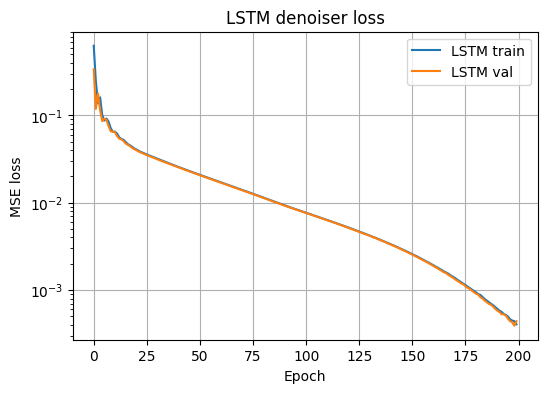

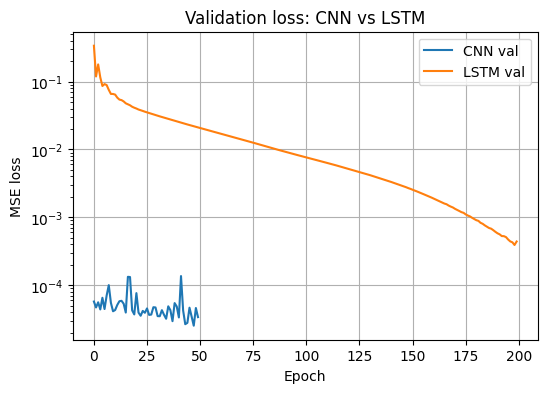

In [19]:
import matplotlib.pyplot as plt

# LSTM loss
plt.figure(figsize=(6,4))
plt.plot(history_lstm.history["loss"], label="LSTM train")
plt.plot(history_lstm.history["val_loss"], label="LSTM val")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("LSTM denoiser loss")
plt.grid(True)
plt.legend()
plt.show()

# Сравнение CNN vs LSTM по val_loss
plt.figure(figsize=(6,4))
plt.plot(history.history["val_loss"], label="CNN val")        # история CNN
plt.plot(history_lstm.history["val_loss"], label="LSTM val")  # история LSTM
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("Validation loss: CNN vs LSTM")
plt.grid(True)
plt.legend()
plt.show()


In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

def snr_db(clean, denoised):
    clean = np.asarray(clean)
    denoised = np.asarray(denoised)
    power_signal = np.mean(clean**2)
    power_noise  = np.mean((clean - denoised)**2)
    return 10.0 * np.log10(power_signal / power_noise)

# Предсказания на всём датасете
y_pred_cnn_3d  = model.predict(X_noisy_3d)    # твой CNN model
y_pred_lstm_3d = lstm_model.predict(X_noisy_3d)

# Разворачиваем для скалярных метрик
y_true_flat  = Y_clean_3d.reshape(-1)
y_noisy_flat = X_noisy_3d.reshape(-1)
y_cnn_flat   = y_pred_cnn_3d.reshape(-1)
y_lstm_flat  = y_pred_lstm_3d.reshape(-1)

# MSE, MAE, R2
mse_cnn  = mean_squared_error(y_true_flat, y_cnn_flat)
mse_lstm = mean_squared_error(y_true_flat, y_lstm_flat)

mae_cnn  = mean_absolute_error(y_true_flat, y_cnn_flat)
mae_lstm = mean_absolute_error(y_true_flat, y_lstm_flat)

r2_cnn   = r2_score(y_true_flat, y_cnn_flat)
r2_lstm  = r2_score(y_true_flat, y_lstm_flat)

# SNR
snr_in   = snr_db(y_true_flat, y_noisy_flat)
snr_cnn  = snr_db(y_true_flat, y_cnn_flat)
snr_lstm = snr_db(y_true_flat, y_lstm_flat)

results = pd.DataFrame({
    "model":      ["CNN", "LSTM"],
    "MSE":        [mse_cnn, mse_lstm],
    "MAE":        [mae_cnn, mae_lstm],
    "R2":         [r2_cnn,  r2_lstm],
    "SNR_out_dB": [snr_cnn, snr_lstm],
})
results["ΔSNR_dB"] = results["SNR_out_dB"] - snr_in

print("Input noisy SNR (dB):", snr_in)
print(results)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
Input noisy SNR (dB): 39.66480467813775
  model       MSE       MAE        R2  SNR_out_dB   ΔSNR_dB
0   CNN  0.000033  0.004118  0.988898   44.549654  4.884849
1  LSTM  0.000395  0.008458  0.866845   33.760178 -5.904627


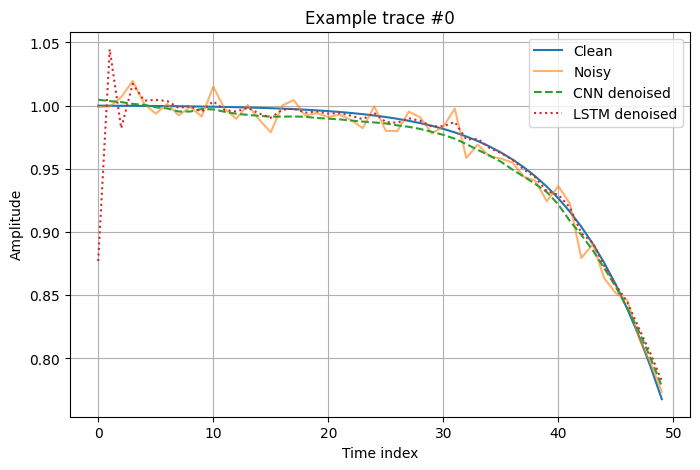

In [21]:
idx = 0  # пример первой кривой

t = np.arange(X_noisy_3d.shape[1])

plt.figure(figsize=(8,5))
plt.plot(t, Y_clean_3d[idx,:,0], label="Clean")
plt.plot(t, X_noisy_3d[idx,:,0], label="Noisy", alpha=0.6)
plt.plot(t, y_pred_cnn_3d[idx,:,0], label="CNN denoised", linestyle="--")
plt.plot(t, y_pred_lstm_3d[idx,:,0], label="LSTM denoised", linestyle=":")
plt.xlabel("Time index")
plt.ylabel("Amplitude")
plt.title(f"Example trace #{idx}")
plt.grid(True)
plt.legend()
plt.show()
